# <span style="color:red"> ***** </span><span style="color:blue"> Perceptual Linear Predictive (PLP) </span> <span style="color:green"> ***** </span>

Perceptual Linear Predictive (PLP) analysis is a popular speech feature extraction technique used in automatic speech recognition systems. PLP aims to model the psychophysics of human hearing more accurately than other methods. Key aspects of PLP include:

Spectral analysis: The speech signal is analyzed using short-term power spectra.
Critical-band spectral resolution: The spectrum is warped along its frequency axis to match the Bark scale, which approximates human auditory perception.
Equal-loudness pre-emphasis: The spectrum is pre-emphasized to simulate the sensitivity of human hearing at different frequencies.
Intensity-loudness power law: A cubic root amplitude compression is applied to simulate the nonlinear relationship between sound intensity and perceived loudness.
Autoregressive modeling: Linear prediction is performed on the modified spectrum to smooth and compress the representation.


PLP processing typically involves the following steps:
    Windowing the speech signal
    Computing the power spectrum
    Applying critical-band integration and resampling
    Equal-loudness pre-emphasis and intensity-loudness conversion
    Performing autoregressive modeling
    Converting LP coefficients to cepstral coefficients

PLP features are similar to Linear Predictive Coding (LPC) but incorporate several perceptually motivated transformations. They often provide better recognition accuracy than traditional LPC, especially in noisy conditions.

An extension of PLP is RASTA-PLP (RelAtive SpecTrAl PLP), which applies a bandpass filter to the time trajectory of each spectral component. This helps reduce the effect of convolutional noise and improves robustness to channel variations.

PLP features are commonly used alongside or as an alternative to Mel-Frequency Cepstral Coefficients (MFCC) in speech recognition systems, offering complementary information about the speech signal.

PLP (Perceptual Linear Prediction) feature extraction combined with an XGBoost classifier:

# <span style="color:red"> ***** </span><span style="color:blue"> Project Data File Folder</span> <span style="color:green"> ***** </span>

In [16]:
import sys, os
parent_dir = os.path.dirname(os.path.realpath('/Users/akpy27/Downloads/Untiltled'))

# To get one directory up from the current file
project_dir = os.path.abspath(os.path.join(parent_dir, "./Untitled/"))

sys.path.insert(0,project_dir)

print ('Parent Directory Path:', parent_dir)
print ('Project Path:', project_dir)

Parent Directory Path: /Users/akpy27/Downloads
Project Path: /Users/akpy27/Downloads/Untitled


In [17]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
import noisereduce as nr

# <span style="color:red"> ***** </span><span style="color:blue"> PLP Feature Extraction</span> <span style="color:green"> ***** </span>

In [18]:

def extract_plp_like_features(audio_file, n_mfcc=13, noise=False):
    audio,sr = torchaudio.load(audio_file)

    sample_audio = audio.numpy().reshape(-1)
    if noise:
        y_preemphasized = librosa.effects.preemphasis(y=sample_audio)
        #reduced_noise = nr.reduce_noise(y_preemphasized,sr=sr)
        S = librosa.feature.melspectrogram(y=y_preemphasized, sr=sr)
    else:
        S = librosa.feature.melspectrogram(y=sample_audio, sr=sr)

    log_S = librosa.power_to_db(S, ref=np.max)

    equal_loudness = librosa.core.A_weighting(librosa.fft_frequencies(sr=sr))
    log_S_eq = log_S + equal_loudness[:log_S.shape[0], np.newaxis]

    log_S_compressed = librosa.power_to_db(10**(log_S_eq / 20), ref=np.max)

    plp_like = librosa.feature.mfcc(S=log_S_compressed, n_mfcc=n_mfcc)
    
    return plp_like



In [19]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [20]:
#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat_plp=[]
train_label=[]

for wav in tqdm(train_files):
  train_feat_plp.append(extract_plp_like_features(wav).mean(axis=1))
  train_label.append(get_label(wav))

  0%|          | 0/8980 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)
100%|██████████| 8980/8980 [02:13<00:00, 67.21it/s]


In [21]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat_plp=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat_plp.append(extract_plp_like_features(wav).mean(axis=1))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [00:38<00:00, 65.08it/s]


In [22]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat_plp=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):
  test_noisy_feat_plp.append(extract_plp_like_features(wav).mean(axis=1))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [00:49<00:00, 65.28it/s]


# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [23]:

import numpy as np
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names_plp=['plp_' +str(n) for n in range(len(train_feat_plp[0]))]

train_feat_df_plp = pd.DataFrame(data=np.stack(train_feat_plp), columns=feat_names_plp)
y_train=np.stack(train_label)

test_clean_feat_df_plp = pd.DataFrame(data=np.stack(test_clean_feat_plp), columns=feat_names_plp)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df_plp = pd.DataFrame(data=np.stack(test_noisy_feat_plp), columns=feat_names_plp)
y_test_noisy=np.stack(test_noisy_label)

# Replace NaN with the mean of the column
train_feat_df_plp.fillna(train_feat_df_plp.mean(), inplace=True)

# Replace infinite values with a large finite number
train_feat_df_plp.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Replace NaN with the mean of the column
test_clean_feat_df_plp.fillna(test_clean_feat_df_plp.mean(), inplace=True)

# Replace infinite values with a large finite number
test_clean_feat_df_plp.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Replace NaN with the mean of the column
test_noisy_feat_df_plp.fillna(test_noisy_feat_df_plp.mean(), inplace=True)

# Replace infinite values with a large finite number
test_noisy_feat_df_plp.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


In [24]:
import xgboost as xgb
import numpy as np
import shap
import pandas as pd

In [25]:

model = xgb.XGBClassifier()

model.fit(train_feat_df_plp,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df_plp))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df_plp))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df_plp))/len(y_test_noisy))

Train Clean Acc = 1.0
Test Clean Acc = 0.4484800631662061
Test Noisy Acc = 0.35948116121062385


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability</span> <span style="color:green"> ***** </span>

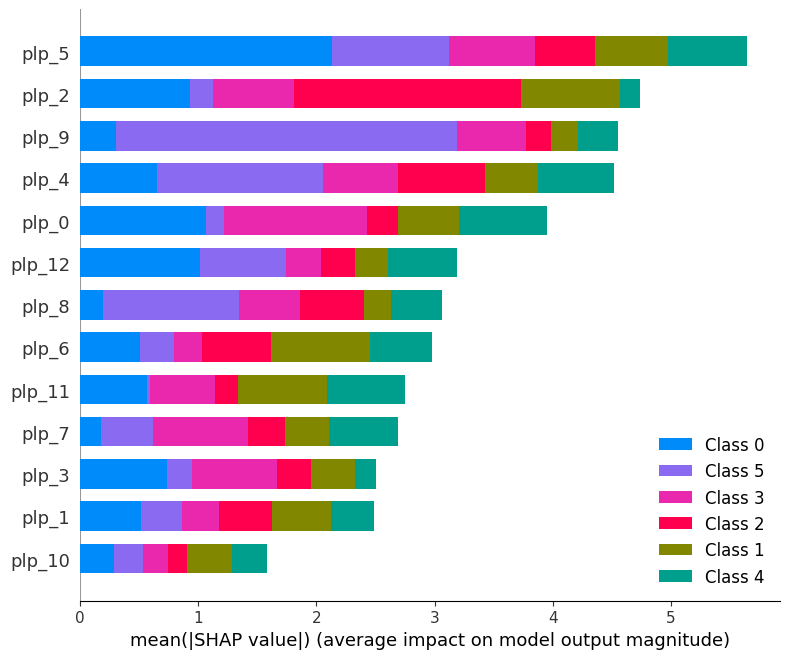

In [26]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(train_feat_df_plp)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_df_plp, plot_type="bar")

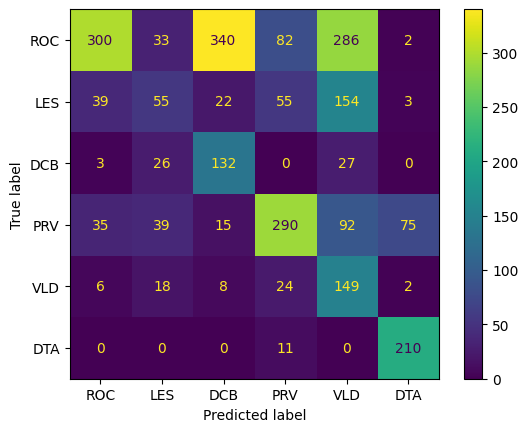

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df_plp))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

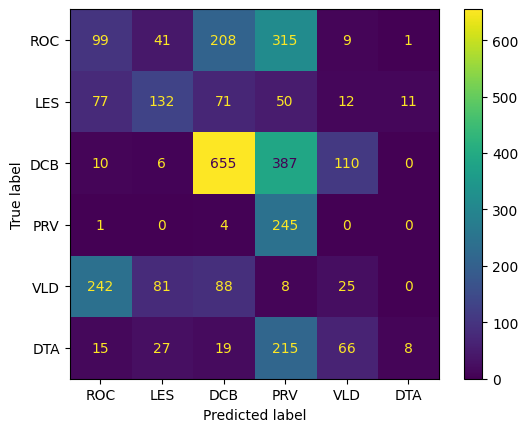

In [28]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df_plp))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()